In [1]:
import sys
sys.path.append('./Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control/')
sys.path.append('./CS159-project/')
sys.path.append('./CS159-project/Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control/')
from gym.envs.classic_control import pendulum
from control_objects.probabilistic_gp_mpc_controller import ProbabiliticGpMpcController
from control_objects.utils import LivePlotClass, LivePlotClassParallel
import numpy as np
import matplotlib.pyplot as plt
import gym
import json
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import torch
import time
import os
import datetime
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
hyperparameters_init = {"noise_std": [1e-2, 1e-2, 1e-2],
                        "lengthscale": [[0.75, 0.75, 0.75, 0.75], 
                                        [0.75, 0.75, 0.75, 0.75], 
                                        [0.75, 0.75, 0.75, 0.75]],
                        "scale": [5e-2, 5e-2, 5e-2]}
params_constraints_hyperparams = {"min_std_noise": 1e-3, 
                                  "max_std_noise": 3e-1, 
                                  "min_outputscale":  1e-10,
                                  "max_outputscale": 1e2,
                                  "min_lengthscale":  4e-5, 
                                  "max_lengthscale": 25.0}
params_controller = {"target_state": [1, 0.5, 0.5], 
                     "weights_target_state": [1, 0.1, 0.1],
                     "weights_target_state_terminal_cost": [10, 3, 3],
                     "target_action": [0.5], 
                     "weights_target_action": [0.1],
                     "s_observation": [1e-6, 1e-6, 1e-6], 
                     "len_horizon": 15, 
                     "exploration_factor": 3,
                     "limit_derivative_actions": 0, 
                     "max_derivative_actions_norm": [0.05],
                     "num_repeat_actions": 1, 
                     "clip_lower_bound_cost_to_0": 0,
                     "compute_factorization_each_iteration": 1}
params_constraints_states = {"use_constraints": 0, 
                             "states_min": [-0.1, 0.05, 0.05], 
                             "states_max":  [1.1, 0.95, 0.925],
                             "area_penalty_multiplier": 2}
params_train = {"lr_train": 7e-3, 
                "n_iter_train": 15, 
                "train_every_n_points": 10, 
                "clip_grad_value": 1e-3,
                "print_train": 0, 
                "step_print_train": 5}
params_actions_optimizer = {"disp": None, 
                            "maxcor": 2, 
                            "ftol": 1e-15, 
                            "gtol": 1e-15, 
                            "eps": 1e-2, 
                            "maxfun": 2,
                            "maxiter": 2, 
                            "iprint": -1, 
                            "maxls": 2, 
                            "finite_diff_rel_step": None}
params_memory = {"min_error_prediction_states_for_storage": [5e-4, 
                                                             5e-4, 5e-4],
                 "min_prediction_states_std_for_storage":  [4e-3, 
                                                            4e-3, 4e-3]}

num_steps = 150
num_random_actions = 25
num_repeat_actions = 1
num_tests = 1

num_training_rollouts = 10
num_training_actions = 10
num_test_steps = 200

# TODO: UNDERSTAND FORMAT OF THIS STATE
target_state = np.array(params_controller['target_state']) 
weights_target_state = np.diag(params_controller['weights_target_state'])
weights_target_state_terminal_cost \
    = np.diag(params_controller['weights_target_state_terminal_cost'])
target_action = np.array(params_controller['target_action'])
weights_target_action = np.diag(params_controller['weights_target_action'])

# I think this has to do with the anticipated covariance of the observations
s_observation = np.diag(params_controller['s_observation'])


<IPython.core.display.Javascript object>


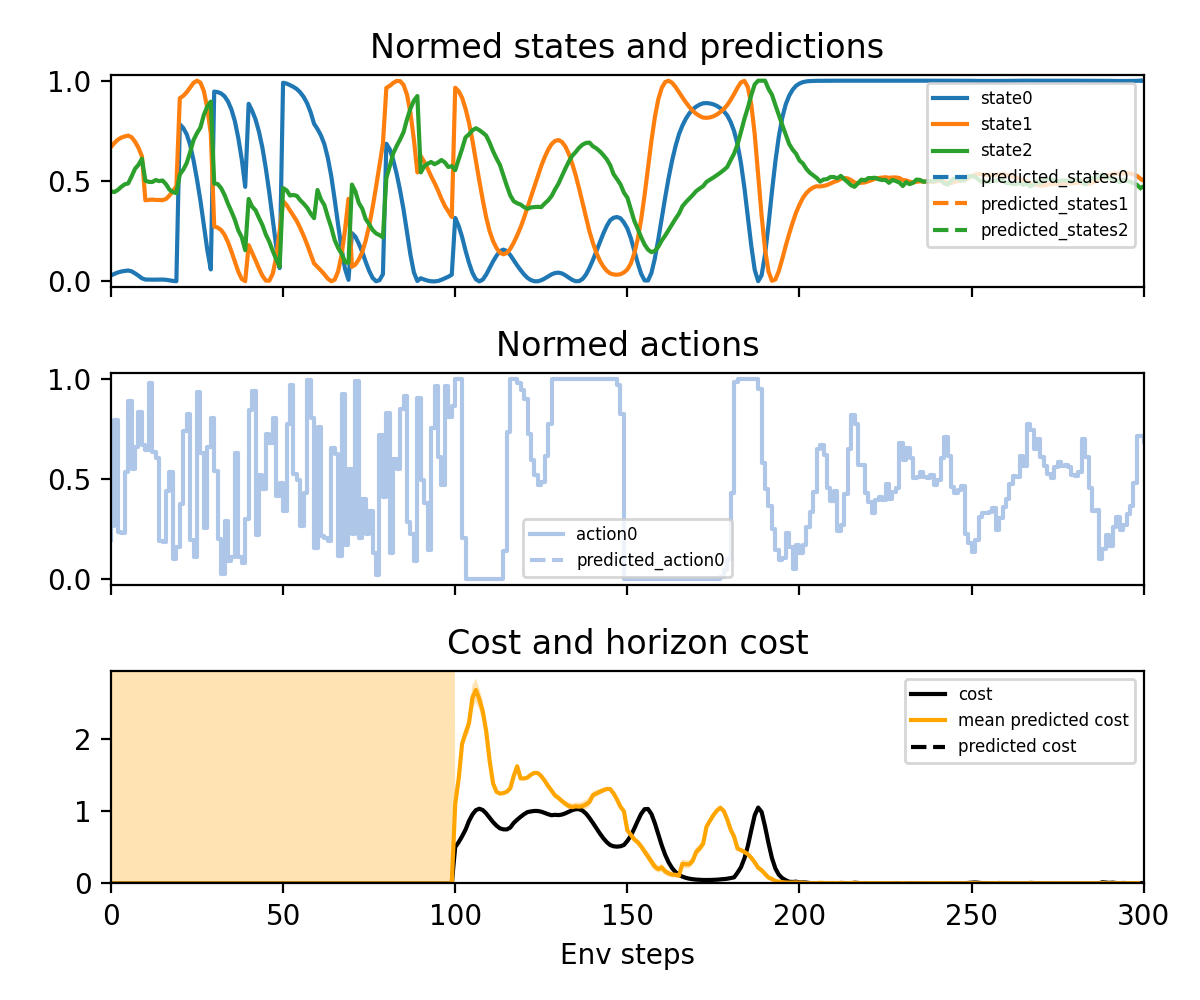

False

In [5]:
%matplotlib notebook

env_to_control = 'Pendulum-v0'
env = pendulum.PendulumEnv(max_torque=2)
env.reset()

datetime_now = datetime.datetime.now()
folder_save = os.path.join('folder_save', env_to_control, 'y' + str(datetime_now.year) \
            + '_mon' + str(datetime_now.month) + '_d' + str(datetime_now.day) + '_h' + str(datetime_now.hour) \
            + '_min' + str(datetime_now.minute) + '_s' + str(datetime_now.second))
if not os.path.exists(folder_save):
    os.makedirs(folder_save)
live_plot_obj = LivePlotClass(num_training_rollouts*num_training_actions 
                              + num_test_steps,
                              env.observation_space, 
                              env.action_space, 
                              params_constraints_states, 
                              num_repeat_actions)

control_object = ProbabiliticGpMpcController(env.observation_space, 
                                             env.action_space, 
                                             params_controller,
                                             params_train, 
                                             params_actions_optimizer, 
                                             params_constraints_states, 
                                             hyperparameters_init,
                                             target_state, 
                                             weights_target_state, 
                                             weights_target_state_terminal_cost,
                                             target_action, 
                                             weights_target_action,
                                             params_constraints_hyperparams, 
                                             env_to_control, 
                                             folder_save, 
                                             num_repeat_actions)

def state_to_obs(state):
    theta, thetadot = state
    return np.array([np.cos(theta), np.sin(theta), thetadot])

def obs_to_state(obs):
    co, si, thetadot = obs
    theta = np.arctan2(si, co)
    return np.array([theta, thetadot])


for idx_rollout in range(num_training_rollouts):
    observation, reward, done, info = env.step(env.action_space.sample())
    for idx_action in range(num_training_actions):
#         observation = env.observation_space.sample()#state_to_obs(env.state)
#         env.state = obs_to_state(observation)
        action = env.action_space.sample()
        noise = np.random.randn()
        control_object.action = np.clip(action + noise, -2, 2)
#         control_object.action = action

        new_observation, reward, _, _ = env.step(np.clip(action + noise, 
                                                         -2, 2))
#         new_observation, reward, _, _ = env.step(action)
        try:
            env.render()
        except:
            pass
        live_plot_obj.add_point_update(observation, action)
        control_object.add_point_memory(observation, action, new_observation, reward)
        observation = new_observation
    env.reset()

losses_tests = np.ones(num_test_steps // num_repeat_actions)
for index_iter in range(num_test_steps):
    observation = state_to_obs(env.state)
    action, add_info_dict = control_object.compute_prediction_action(observation, s_observation)
    for idx_action in range(num_repeat_actions):
        noise = np.random.randn()
        true_action = np.clip(action + noise, -2, 2)
        new_observation, reward, done, info = env.step(true_action)
#         new_observation, reward, done, info = env.step(action)
        try:
            env.render()
        except:
            pass
    losses_tests[index_iter] = add_info_dict['cost']
    control_object.add_point_memory(observation, action, new_observation, reward,
                                    add_info_dict=add_info_dict, params_memory=params_memory)
    live_plot_obj.add_point_update(observation, action, add_info_dict)
    observation = new_observation
    
env.__exit__()

In [6]:
env = pendulum.PendulumEnv(max_torque=2)
env.seed(14)
env.reset()

obs_variance = 1e-6

s_observation = np.diag(np.full(3, obs_variance))#obs_variance))
num_test_steps = 100
losses_tests = np.ones(num_test_steps)
state_history = np.zeros((num_test_steps,3))
control_history = np.zeros(num_test_steps)
loss_history = np.zeros(num_test_steps)

observation = state_to_obs(env.state)
for index_iter in tqdm(range(num_test_steps)):
    state_history[index_iter] = observation
    action, add_info_dict = control_object.compute_prediction_action(observation, s_observation)
    noise = np.random.randn()
    control_history[index_iter] = action + noise
#     noise = np.sqrt(obs_variance)*np.random.randn(1)
    new_observation, reward, done, info = env.step(action + noise)
    try:
        env.render()
    except:
        pass
    loss_history[index_iter] = add_info_dict['cost']
#     print(add_info_dict)
#     gp_model.add_point_memory(observation, action, new_observation, reward,
#                                     add_info_dict=add_info_dict, params_memory=params_memory)
#     live_plot_obj.add_point_update(observation, action, add_info_dict)
    observation = new_observation

<ipython-input-6-bd7cfe287bed>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index_iter in tqdm(range(num_test_steps)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
states = np.array([obs_to_state(obs) for obs in state_history])

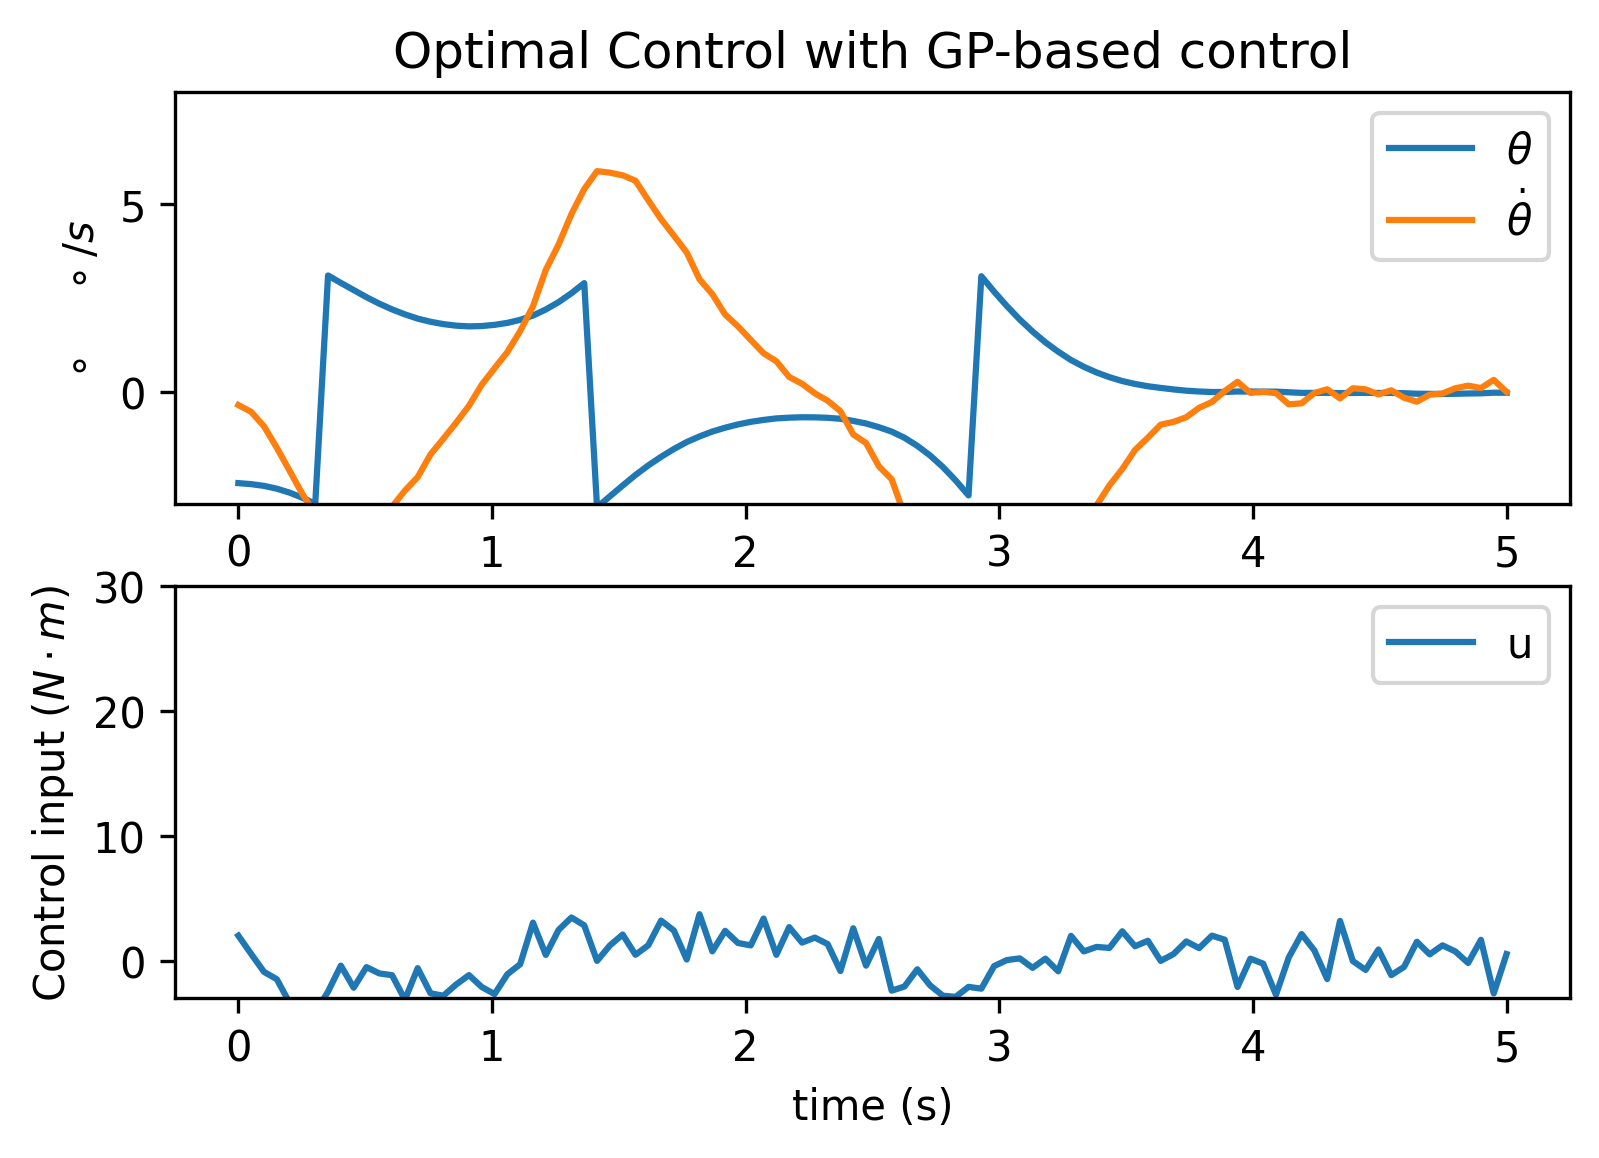

In [8]:
%matplotlib inline
dt = env.dt
ts = np.linspace(0, num_test_steps*dt, num_test_steps)

plt.figure(dpi=300)
plt.subplot(211)
plt.plot(ts, states[:, 0], label=r"$\theta$")
plt.plot(ts, states[:, 1], label=r"$\dot{\theta}$")
plt.ylabel(r"$\circ \ \ \ \ \circ/s$")
plt.legend()
plt.title("Optimal Control with GP-based control")
xlim_new = (-0.25,5.25)
plt.xlim(xlim_new)
plt.ylim((-3,8))
plt.subplot(212)
plt.plot(ts, control_history, label="u")
plt.xlabel('time (s)')
plt.ylabel(r"Control input ($N \cdot m$)")
plt.xlim(xlim_new)
plt.ylim((-3,30))
plt.legend()
plt.show()